<a href="https://colab.research.google.com/github/aruaru0/bert-classification-test/blob/main/HuggingFace_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transformerのインストールなど

In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install git+https://github.com/huggingface/accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-5yfpp72o
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-

In [2]:
!pip install fugashi
!pip install ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556703 sha256=2508f3e2150ff960377050ff7c13104b6f59da3516ed0a3a4d3c500dc61eeb70
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


# データセットを準備

In [3]:
from datasets import load_dataset

dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
                                                text     label  \
0  普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しか...  negative   
1  十分な在庫を用意できない販売元も悪いですが、Amazonやら楽⚪︎が転売を認めちゃってるのが...  negative   
2  見た目はかなりおしゃれで気に入りました。2、3回持ち歩いた後いつも通りゼンマイを巻いていたら...  negative   
3  よくある部分での断線はしませんでした ただiphoneとの接続部で接触不良、折れました ip...  negative   
4  プラモデルの塗装剥離に使う為に購入 届いて早速使ってみた 結果 １ヶ月経っても未だに剥離出来...  negative   

                 source  
0  amazon_reviews_multi  
1  amazon_reviews_multi  
2  amazon_reviews_multi  
3  amazon_reviews_multi  
4  amazon_reviews_multi  
----------------------------------------------------------------------------------------------------


Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
                                                text     label  \
0  味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５本のうち２本が蒸気も出ず、吸い込...  negative   
1             ホームボタン周りの気泡が全く抜けません。 返金をお願いしましたが、断られた。  negative   
2  新旧含めて4つのカーテンレールがあるのですが、使用出来るカーテンレールはありませんでした。 ...  negative   
3            予約注文でしたが、どこから特典であるpdfダウンロードすればよいのでしょうか…  negative   
4  前のレビューにもありましたが、片方が全く動きません。 返品しようにも、なんだかめんどくさいし...  negative   

                 source  
0  amazon_reviews_multi  
1  amazon_reviews_multi  
2  amazon_reviews_multi  
3  amazon_reviews_multi  
4  amazon_reviews_multi  
----------------------------------------------------------------------------------------------------


Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
                                                text     label  \
0  購入、貼付け後2週間もたたないうちに、上側から剥がれてきて画面から浮いた状態になってしまった...  negative   
1  以下の3点の理由により、期待はずれの粗悪品。 ①他の方のレビューにもある通り、天板の外観が掲...  negative   
2  この商品の内容等確認した購入したのですが、そのとおりなかなか設定ができなく、知人にもお願いし...  negative   
3  テストした結果、4000mahのスマホ一回と30％分、スマホのバッテリー残量の表示が正しけれ...  negative   
4  前回の黒いドレッサーバッグの評判がよかったため、予約して購入しました。 ガッカリです。 ヨレ...  negative   

                 source  
0  amazon_reviews_multi  
1  amazon_reviews_multi  
2  amazon_reviews_multi  
3  amazon_reviews_multi  
4  amazon_reviews_multi  
----------------------------------------------------------------------------------------------------


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
})

# Tokenizerの取得

In [5]:
from transformers import AutoTokenizer

model_ckpt = "cl-tohoku/bert-base-japanese"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# データサイズを減らす

In [6]:
SEED = 42
TRAIN_SIZE = 10000
TEST_SIZE = 1000

dataset["train"] = dataset["train"].shuffle(seed=SEED).select(range(TRAIN_SIZE))
dataset["validation"] = dataset["validation"].shuffle(seed=SEED).select(range(TEST_SIZE))
dataset["test"] = dataset["test"].shuffle(seed=SEED).select(range(TEST_SIZE))

# データセットの加工

In [7]:
import torch

def tokenize(batch):
    enc =  tokenizer(batch["text"], padding=True, truncation=True)
    enc.update({'label': batch['label']})
    return enc

In [8]:
dataset_encoded = dataset.map(tokenize)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
small_train_dataset = dataset_encoded['train']
small_valid_dataset = dataset_encoded['validation']
small_test_dataset = dataset_encoded['test']

# 学習

In [10]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 5

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    preds, labels = pred
    preds = preds.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [12]:
from transformers import TrainingArguments

batch_size = 16
logging_steps = len(small_train_dataset) // batch_size
model_name = "multilingual-sentiments-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_train_dataset,
    eval_dataset=small_valid_dataset,
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.625500,0.527101,0.787000,0.771537
2,0.388300,0.477188,0.798000,0.795739


TrainOutput(global_step=1250, training_loss=0.506934033203125, metrics={'train_runtime': 754.0556, 'train_samples_per_second': 26.523, 'train_steps_per_second': 1.658, 'total_flos': 2005872936632352.0, 'train_loss': 0.506934033203125, 'epoch': 2.0})

# テストデータに対する結果を評価


In [14]:
preds_output = trainer.predict(small_test_dataset)

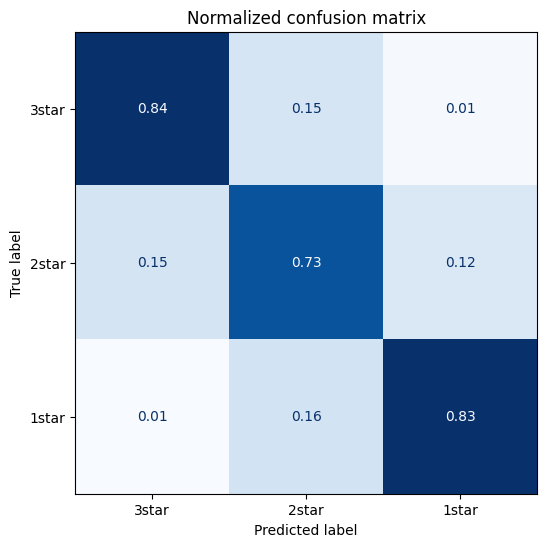

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(small_test_dataset["label"])
labels = ["3star", "2star", "1star"]
#dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

# モデルの保存、読み込み

In [16]:
trainer.save_model(f"./{model_name}-test")

In [17]:
tokenizer = AutoTokenizer\
    .from_pretrained(f"./{model_name}-test")

model = (AutoModelForSequenceClassification
    .from_pretrained(f"./{model_name}-test")
    .to(device))

# Pipelineを使って推論

In [18]:
from transformers import pipeline

pipe = pipeline("text-classification", f"./{model_name}-test")
pipe("同価格帯のガン型電ドラより力が入りにくいが、手回しより楽です。締めすぎないので良いです。")

[{'label': 'LABEL_0', 'score': 0.9005647301673889}]